### Imports

In [1]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from xgboost import XGBClassifier

# optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# shap
import shap
shap.initjs()

# utils
from utils import *

In [2]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [3]:
#creating an objective function
def objective(trial):
    
    #hyperparameters to tune
    param = {
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 9),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 1e-8, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 1, 1000),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight",1, 25)
    }

    #creating the model
    xgbr = XGBClassifier(seed = 20, **param)
    xgbr.fit(X_train, y_train)

    #classifying validation data
    y_pred = xgbr.predict(X_valid)

    #measuring the evaluation metrics for the model
    recall = recall_score(y_valid, y_pred)
    return recall

In [4]:
#running 100 trials to find the hyperparameters that give the highest evaluation metric score
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : objective(trial) ,n_trials=50)
print("Number of finished trials: ", len(study.trials))

[22:19:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:25] WARNING:

In [5]:
#view the best hyperparameters
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 0
	params: {'lambda': 0.0019483156127116112, 'min_child_weight': 3, 'alpha': 6.157446938358615e-08, 'max_depth': 8, 'eta': 7.97179777567621e-08, 'gamma': 0.9805317860486497, 'grow_policy': 'depthwise', 'colsample_bytree': 4.620051220395032e-07, 'n_estimators': 657, 'scale_pos_weight': 12}
	values: [1.0]


In [6]:
test = XGBClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train,y_train)

# make predictions for validation data
y_pred = test.predict(X_valid)
predictions = [round(value) for value in y_pred]


[22:21:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
# evaluate predictions
get_scores(y_valid, predictions)

Precision: 0.059
Accuracy: 0.059
Recall: 1.000
F1: 0.112
Fbeta: 0.239
ROC AUC: 0.500
PR AUC: 0.059


<AxesSubplot:title={'center':'Tuned for recall'}, xlabel='Predictions', ylabel='True Labels'>

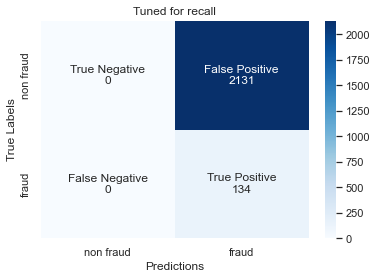

In [8]:
get_confusion_matrix(y_valid,y_pred, "Tuned for recall")

#### Finding hyperparameter with the best f2 score

In [9]:
#creating an objective function
def objective(trial):

    #hyperparameters to tune
    param = {
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 9),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 1e-8, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 1, 1000),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight",1, 25)
    }

    #creating the model
    xgbr = XGBClassifier(seed = 20, **param)
    xgbr.fit(X_train, y_train)

    #classifying validation data
    y_pred = xgbr.predict(X_valid)

    #measuring the evaluation metrics for the model
    fbeta = fbeta_score(y_valid, y_pred, beta = 2)
    return fbeta

In [10]:
#running 100 trials to find the hyperparameters that give the highest evaluation metric scores
study2 = optuna.create_study(direction="maximize")
study2.optimize(lambda trial : objective(trial) ,n_trials=50)
print("Number of finished trials: ", len(study2.trials))

[22:21:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:07] WARNING:

In [11]:
#view the best hyperparameters
trial = study2.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 43
	params: {'lambda': 0.12635902372529212, 'min_child_weight': 9, 'alpha': 0.0002417595635207393, 'max_depth': 4, 'eta': 0.37313593726806393, 'gamma': 9.185019168570613e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0.32147627604917134, 'n_estimators': 970, 'scale_pos_weight': 25}
	values: [0.39339103068450043]


In [12]:
#fit a model with the hyperparameters
test = XGBClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train,y_train)

# make predictions for validation data
y_pred = test.predict(X_valid)

get_scores(y_valid, y_pred)

[22:25:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision: 0.136
Accuracy: 0.705
Recall: 0.746
F1: 0.230
Fbeta: 0.393
ROC AUC: 0.724
PR AUC: 0.117


<AxesSubplot:title={'center':'Tuned for fbeta'}, xlabel='Predictions', ylabel='True Labels'>

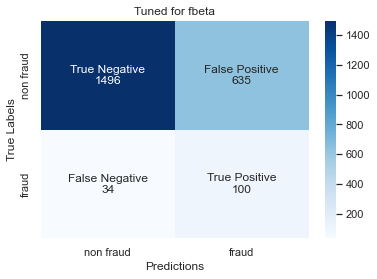

In [13]:
#Confusion Matrix
get_confusion_matrix(y_valid,y_pred, "Tuned for fbeta")

#### Making predictions on test set

In [14]:
# make predictions for test data
y_pred2 = test.predict(X_test)
predictions = [round(value) for value in y_pred2]

get_scores(y_test, y_pred2)

Precision: 0.132
Accuracy: 0.720
Recall: 0.672
F1: 0.221
Fbeta: 0.370
ROC AUC: 0.697
PR AUC: 0.108


<AxesSubplot:title={'center':'Test set results'}, xlabel='Predictions', ylabel='True Labels'>

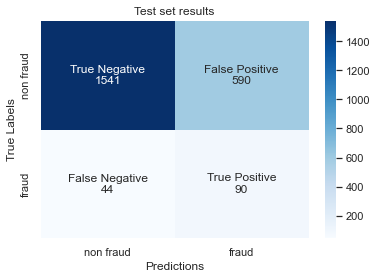

In [15]:
#Confusion Matrix
get_confusion_matrix(y_test, y_pred2, "Test set results")

### SHAP

In [16]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
feature_dict = {}
for num in range(53):
    feature_key = "f" + str(num)
    feature_dict[feature_key] = features[num]
print(feature_dict)

{'f0': 'MonthClaimed', 'f1': 'VehiclePrice', 'f2': 'Deductible', 'f3': 'DriverRating', 'f4': 'Days_Policy_Accident', 'f5': 'Days_Policy_Claim', 'f6': 'PastNumberOfClaims', 'f7': 'AgeOfVehicle', 'f8': 'AgeOfPolicyHolder', 'f9': 'NumberOfSuppliments', 'f10': 'AddressChange_Claim', 'f11': 'NumberOfCars', 'f12': 'Year', 'f13': 'AccidentArea_IsUrban', 'f14': 'Sex_IsMale', 'f15': 'Fault_IsPolicyholder', 'f16': 'PoliceReportFiled_IsYes', 'f17': 'WitnessPresent_IsYes', 'f18': 'AgentType_IsExternal', 'f19': 'isWithinAgeRange_IsTrue', 'f20': 'Make_Accura', 'f21': 'Make_BMW', 'f22': 'Make_Chevrolet', 'f23': 'Make_Dodge', 'f24': 'Make_Ford', 'f25': 'Make_Honda', 'f26': 'Make_Jaguar', 'f27': 'Make_Lexus', 'f28': 'Make_Mazda', 'f29': 'Make_Mecedes', 'f30': 'Make_Mercury', 'f31': 'Make_Nisson', 'f32': 'Make_Pontiac', 'f33': 'Make_Porche', 'f34': 'Make_Saab', 'f35': 'Make_Saturn', 'f36': 'Make_Toyota', 'f37': 'Make_VW', 'f38': 'MaritalStatus_Divorced', 'f39': 'MaritalStatus_Married', 'f40': 'MaritalSt

In [17]:
X_display = df_train.drop('FraudFound_P', axis=1)

In [18]:
explainer = shap.TreeExplainer(test)
shap_values = explainer.shap_values(X_train)


In [19]:
#how features affect the classification of the first data point
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [20]:
#how features affect the classification of the first 1000 data points
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

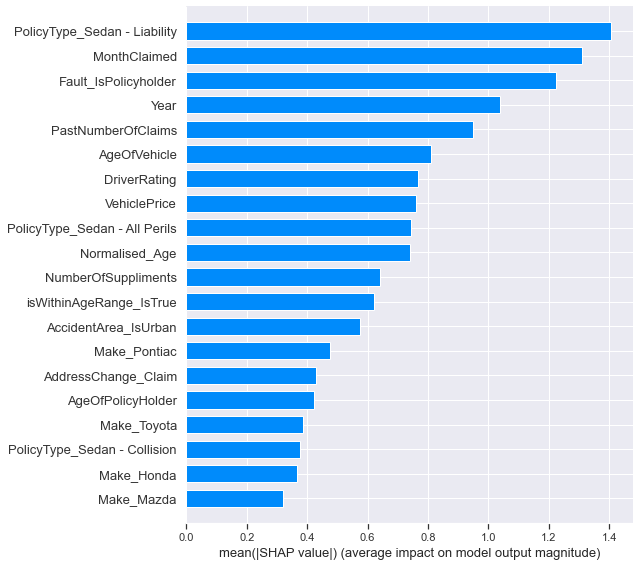

In [21]:
#featuere importance
shap.summary_plot(shap_values, X_display, plot_type="bar")

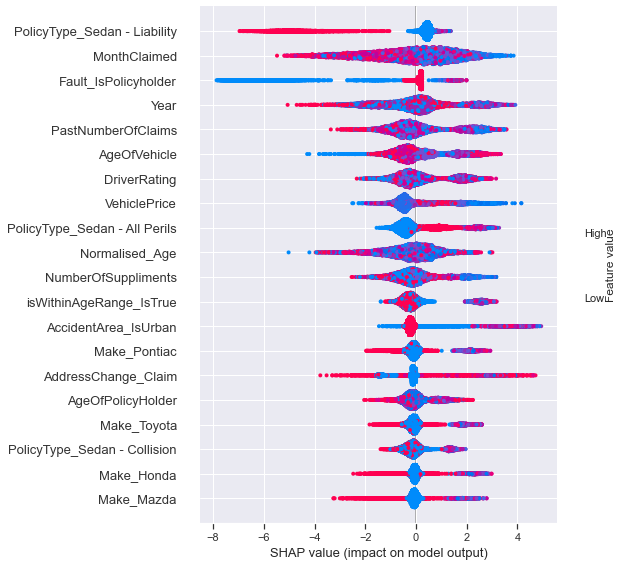

In [22]:
#plot a summary plot of all the features and how the value of the feaures affect SHAP value
shap.summary_plot(shap_values, X_train, features)